<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/Projet_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import shutil
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor
from sklearn.cluster import KMeans

In [2]:
shutil.rmtree('/content/metadata', ignore_errors=True)
shutil.rmtree('/content/train', ignore_errors=True)
shutil.rmtree('/content/validation', ignore_errors=True)

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/wider_face_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/metadata/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/train/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_val.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/validation/')

In [4]:
features = [32, 16, 8]
k = 9
number_of_bbx_per_scale = k // len(features)
valid_indices = []
for i in range(len(features)):
  valid_indices.append(list(range(i * number_of_bbx_per_scale, (i + 1) * number_of_bbx_per_scale)))
image_size = 256
ignore_threshold = 0.5
batch_size = 32
epochs = 10

In [5]:
def get_right_images(filepath_train, filepath_val, top_path_train, top_path_val):
  map_filename_bbx = {}
  for filepath, top_path in zip([filepath_train, filepath_val], [top_path_train, top_path_val]):
    with open(filepath) as file:
      lines = file.read().splitlines()
      file_name_line_number = 0
      face_line_number = 0
      while file_name_line_number < len(lines):
        number_of_faces = int(lines[file_name_line_number + 1])
        if number_of_faces is 0:
          number_of_faces += 1
        values = []
        key = lines[file_name_line_number]
        while face_line_number < number_of_faces:
          fields = lines[file_name_line_number + 2 + face_line_number].split()
          fields = list(map(int, fields))
          if fields[4] is not 0 or fields[5] is not 0 or fields[6] is not 0 or fields[7] is not 0 or fields[8] is not 0 or fields[9] is not 0:
            face_line_number += 1
            values = []
            break
          value = np.array([x for x in fields[:4]])
          if len(value) > 0:
            values.append(value)
          face_line_number += 1
        if values:
          map_filename_bbx[top_path + key] = values
        file_name_line_number += number_of_faces + 2
        face_line_number = 0
  return map_filename_bbx

In [6]:
def get_aspect_ratio(right_images):
  aspect_ratio_list = []
  for key in list(right_images):
    image_size = Image.open(key).size
    if image_size[0] < image_size[1]:
      del right_images[key]
      continue
    aspect_ratio_list.append(float(image_size[0]) / float(image_size[1]))
  return right_images

In [7]:
def standardize_images(images):
  means = images.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
  stds = images.std(axis=(0,1,2), keepdims=True).astype(np.float32)
  images = (images - means) / stds
  return images.astype(np.float32)

def normalize_images(images):
  maxs = images.max(axis=(0,1,2), keepdims=True).astype(np.float32)
  mins = images.min(axis=(0,1,2), keepdims=True).astype(np.float32)
  images = (images - mins) / (maxs - mins)
  return images.astype(np.float32)

In [8]:
def get_iou(bbx1, bbx2):
  x_left = np.maximum(bbx1[..., 0], bbx2[..., 0])
  y_top = np.maximum(bbx1[..., 1], bbx2[..., 1])
  x_right = np.minimum(bbx1[..., 0] + bbx1[..., 2], bbx2[..., 0] + bbx2[..., 2])
  y_bottom = np.minimum(bbx1[..., 1] + bbx1[..., 3], bbx2[..., 1] + bbx2[..., 3])

  intersection_area = (np.maximum(np.zeros(x_right.shape), x_right - x_left) * np.maximum(np.zeros(y_bottom.shape), y_bottom - y_top)).astype(np.float32)

  bbx1_area = bbx1[..., 2] * bbx1[..., 3]
  bbx2_area = bbx2[..., 2] * bbx2[..., 3]

  iou = intersection_area / (bbx1_area + bbx2_area - intersection_area)
  iou = np.nan_to_num(iou)
  return iou

In [9]:
def get_iou_not_same_shape(boxes, predictions):

    boxes = tf.expand_dims(boxes, 0)
    predictions = tf.expand_dims(predictions, 1)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(predictions), tf.shape(boxes))
    boxes = tf.broadcast_to(boxes, new_shape)
    predictions = tf.broadcast_to(predictions, new_shape)

    x_box = boxes[..., 0]
    y_box = boxes[..., 1]
    w_box = boxes[..., 2]
    h_box = boxes[..., 3]

    x_pred = predictions[..., 0]
    y_pred = predictions[..., 1]
    w_pred = predictions[..., 2]
    h_pred = predictions[..., 3]

    x_left = tf.math.maximum(x_box, x_pred)
    y_top = tf.math.maximum(y_box, y_pred)
    x_right = tf.math.minimum(x_box + w_box, x_pred + w_pred)
    y_bottom = tf.math.minimum(y_box + h_box, y_pred + h_pred)

    intersection_area = tf.math.maximum(0, x_right - x_left) * tf.math.maximum(0, y_bottom - y_top)

    boxes_area = w_box * h_box
    predictions_area = w_pred * h_pred

    union = boxes_area + predictions_area - intersection_area

    iou = intersection_area / union
    iou = tf.where(tf.math.is_nan(iou), tf.ones_like(iou) * 0, iou)

    return iou

In [10]:
def get_images_and_bbxs(right_images):
    image_list = []
    bbx_list = []
    for item in right_images.items():
      image = Image.open(item[0])

      image = np.array(image)
      ratio = min(image_size / image.shape[1], image_size / image.shape[0])
      new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
      image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

      padding_amount_rows = (image_size - image.shape[0]) / 2
      padding_amount_cols = (image_size - image.shape[1]) / 2

      values = []
      for bbx in item[1]:
        if (bbx==0).all():
          continue
        new_bbx = bbx * ratio
        new_bbx[0] += padding_amount_cols
        new_bbx[1] += padding_amount_rows
        values.append(new_bbx)
      
      if not values:
        continue
      
      bbxs = (np.stack(values) / image_size).astype(np.float32)

      image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
      image_list.append(image)
      bbx_list.append(bbxs)
        
    images = np.stack(image_list)
    return images, bbx_list

In [11]:
def get_best_anchor_indices(boxes, anchors):
  boxes = np.tile(boxes[:, np.newaxis, :], [1, anchors.shape[0], 1])
  anchors = np.tile(anchors[np.newaxis, :, :], [boxes.shape[0], 1, 1])
  intersections = np.minimum(boxes[..., 0], anchors[..., 0]) * np.minimum(boxes[..., 1], anchors[..., 1])
  boxes_area = boxes[..., 0] * boxes[..., 1]
  anchors_area = anchors[..., 0] * anchors[..., 1]
  ious = intersections / (boxes_area + anchors_area - intersections)
  ious = np.nan_to_num(ious)
  return np.argmax(ious, axis=1)

In [12]:
def set_labels(bbx_list, anchors, features, valid_indices):
  cell_size = 1.0 / features
  Y = np.zeros((len(bbx_list), features, features, len(valid_indices), 5), dtype=np.float32)
  for image_index, bbxs in enumerate(bbx_list):
    object_midpoint = np.concatenate([(bbxs[:, 0] + (bbxs[:, 2] / 2)).reshape((-1, 1)), (bbxs[:, 1] + (bbxs[:, 3] / 2)).reshape((-1, 1))], axis=1)
    indices_anchors = get_best_anchor_indices(bbxs[:, 2:], anchors)
    mask = np.isin(indices_anchors, valid_indices)
    object_midpoint = object_midpoint[mask, :]
    indices_anchors = indices_anchors[mask] % number_of_bbx_per_scale
    cell_index = np.floor(object_midpoint * features).astype(np.int32)
    wh = bbxs[:, 2:][mask, :]
    assert(wh.shape[0] == cell_index.shape[0] == indices_anchors.shape[0] == object_midpoint.shape[0])
    if len(indices_anchors) == 0:
      continue
    Y[image_index, cell_index[:, 1], cell_index[:, 0], indices_anchors, :] = np.stack([np.ones_like(object_midpoint[:, 0]), object_midpoint[:, 0], object_midpoint[:, 1], wh[:, 0], wh[:, 1]], axis=-1)
  return Y

In [13]:
from sklearn.model_selection import train_test_split

right_images = get_right_images('/content/metadata/wider_face_split/wider_face_train_bbx_gt.txt', '/content/metadata/wider_face_split/wider_face_val_bbx_gt.txt', '/content/data/train/WIDER_train/images/', '/content/data/validation/WIDER_val/images/')
print(len(right_images))

4771


In [14]:
def get_bbxs_clusters(bbx_list):
  widths_and_heights = []
  for bbx in bbx_list:
    widths_and_heights.append(bbx[:, 2:])
  X = np.concatenate(widths_and_heights, axis=0)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
  anchors = kmeans.cluster_centers_.astype(np.float32).reshape((-1, 2))
  areas = np.prod(anchors, axis=1)
  indices = np.argsort(areas)
  sorted_anchors = anchors[indices]
  return sorted_anchors

In [15]:
images, bbx_list = get_images_and_bbxs(right_images)
anchors = get_bbxs_clusters(bbx_list)
print(anchors)
print(images.shape)

[[0.03278016 0.04092728]
 [0.06651902 0.08967111]
 [0.09805764 0.13433121]
 [0.13662681 0.18527794]
 [0.17984447 0.24516846]
 [0.23487213 0.3169095 ]
 [0.29764575 0.40217566]
 [0.372976   0.50065506]
 [0.5116139  0.65165365]]
(4763, 416, 416, 3)


In [16]:
Y_large = set_labels(bbx_list, anchors, features[2], valid_indices[2])
print(Y_large.shape)
Y_medium = set_labels(bbx_list, anchors, features[1], valid_indices[1])
print(Y_medium.shape)
Y_small = set_labels(bbx_list, anchors, features[0], valid_indices[0])
print(Y_small.shape)
Y = [Y_small, Y_medium, Y_large]
print(len(bbx_list))

(4763, 13, 13, 3, 5)
(4763, 26, 26, 3, 5)
(4763, 52, 52, 3, 5)
4763


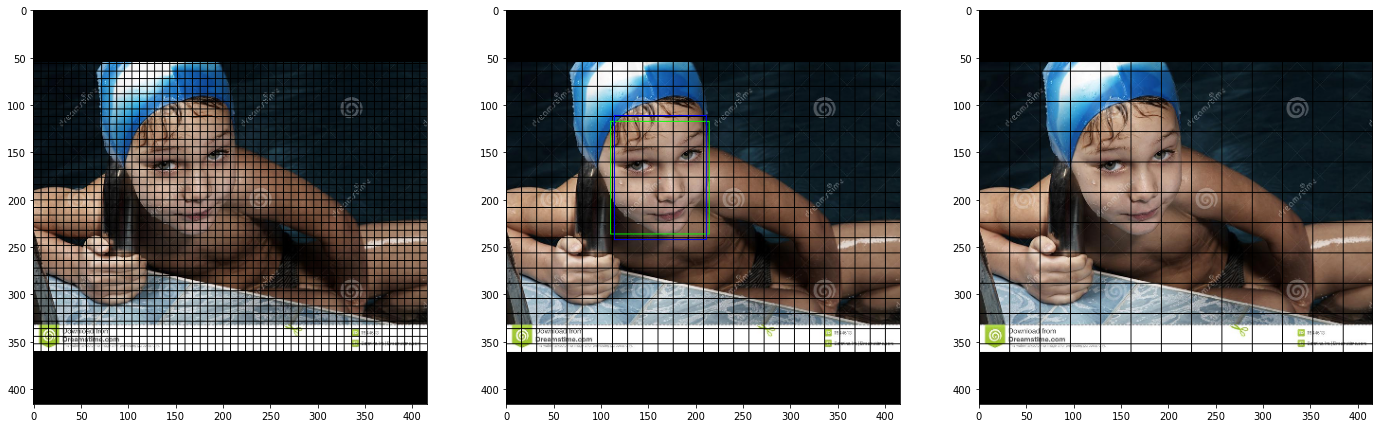

In [17]:
fig, ax = plt.subplots(1, len(features), figsize=(24, 10))
index = np.random.randint(0, Y[0].shape[0])
test_image = images[index].copy()

for index_feature, (feature, y) in enumerate(zip(features, Y)):
  Y_test = y[index]
  current_image = test_image.copy()
  cell_size = image_size / feature
  current_image[::int(cell_size), :, :] = 0
  current_image[:, ::int(cell_size), :] = 0
  for i in range(Y_test.shape[0]):
    for j in range(Y_test.shape[1]):
      for t in range(Y_test.shape[2]):
        if Y_test[i, j, t, :].any():
          bbox = Y_test[i, j, t, 1:]
          anchor_index = number_of_bbx_per_scale * index_feature + t
          w_h_box = (anchors[anchor_index] * image_size).astype(np.int32)
          w_h_true = (bbox[2:] * image_size).astype(np.int32)
          object_midpoint_x_y = bbox[0:2] * image_size
          current_image[int(object_midpoint_x_y[1]), int(object_midpoint_x_y[0]), :] = np.array([255, 0, 0])
          x_y_true = np.maximum(0, object_midpoint_x_y - (w_h_true / 2)).astype(np.int32)
          x_y_box = np.maximum(0, object_midpoint_x_y - (w_h_box / 2)).astype(np.int32)
          current_image = cv.rectangle(current_image, (x_y_true[0], x_y_true[1]), (x_y_true[0] + w_h_true[0], x_y_true[1] + w_h_true[1]), (0, 255, 0), 1)
          current_image = cv.rectangle(current_image, (x_y_box[0], x_y_box[1]), (x_y_box[0] + w_h_box[0], x_y_box[1] + w_h_box[1]), (0, 0, 255), 1)
  ax[index_feature].imshow(current_image)

In [ ]:
images = standardize_images(images)
#images = normalize_images(images)

del right_images
all_indices = list(range(images.shape[0]))
train_indices, test_indices = train_test_split(all_indices, test_size=0.1, random_state=42)
del all_indices
X_test = images[test_indices, ...]
Y_test = [bbx_list[i] for i in test_indices]

train_indices, test_indices = train_test_split(train_indices, test_size=0.1, random_state=42)
X_train = images[train_indices, ...]
X_val = images[test_indices, ...]
del images
Y_val = [bbx_list[i] for i in test_indices]
del test_indices
Y_train = []
for y in Y:
  Y_train.append(y[train_indices, ...])
del Y
boxes_train = [bbx_list[i] for i in train_indices]
del train_indices

print(X_train.shape)
print(Y_train[0].shape)
print(X_val.shape)
print(len(Y_val))
print(X_test.shape)
print(len(Y_test))
print(len(boxes_train))

In [ ]:
def get_object_loss(bo, label, noobj_mask, lambda_obj, lambda_noobj):
  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss_conf_obj = tf.reduce_sum(label * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  loss_conf_noobj = tf.reduce_sum(noobj_mask * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  return (lambda_obj * loss_conf_obj) + (lambda_noobj * loss_conf_noobj)

In [ ]:
def get_location_loss(label, prediction, t_xy, t_wh, lambda_xy, lambda_wh):
  loss_xy = tf.reduce_sum(label * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
  loss_wh = tf.reduce_sum(label * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))
  return (lambda_xy * loss_xy) + (lambda_wh * loss_wh)

In [ ]:
def loss(box_list, features, anchors, w_xy, w_wh, w_obj, w_non_obj):
  def get_loss_sub(label, prediction):
    grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    #grid = tf.tile(grid, (1, 1, anchors.shape[0], 1))

    bx_by = tf.math.sigmoid(prediction[..., 1:3]) + grid
    bx_by = bx_by / tf.cast(features, tf.float32)
    bo = tf.math.sigmoid(prediction[..., 0])
    bw_bh = tf.exp(prediction[..., 3:]) * anchors
    bx_by = tf.maximum(0, bx_by - bw_bh / 2)
    abs_predictions = tf.reshape(tf.concat([bx_by, bw_bh], axis=-1), (label.shape[0], -1, 4))

    ious = []
    for index, boxes in enumerate(box_list):
      current_pred = abs_predictions[index]
      #print(np.unique(current_pred))
      iou = get_iou_not_same_shape(boxes, current_pred)
      ious.append(np.amax(iou, axis=1))
    ious = np.stack(ious).reshape((label.shape[0], features, features, len(anchors)))

    noobj_mask = tf.cast(ious < ignore_threshold, tf.float32) * (1 - label[..., 0])

    t_wh = tf.math.log(label[..., 3:] / anchors)
    t_wh = tf.where(tf.logical_or(tf.math.is_inf(t_wh), tf.math.is_nan(t_wh)), tf.zeros_like(t_wh), t_wh)
    t_xy = label[..., 1:3] * features - grid

    #loss_xy = tf.reduce_sum(label[..., 0] * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
    #loss_wh = tf.reduce_sum(label[..., 0] * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))

    location_loss = get_location_loss(label[..., 0], prediction, t_xy, t_wh, w_xy, w_wh)

    #loss_conf_obj = tf.reduce_sum(label[..., 0] * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    #loss_conf_noobj = tf.reduce_sum(noobj_mask * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    object_loss = get_object_loss(bo, label[..., 0], noobj_mask, w_obj, w_non_obj)

    #total_loss = 5 * loss_xy + 5 * loss_wh + 5 * loss_conf_obj + 0.5 * loss_conf_noobj
    total_loss = location_loss + object_loss

    return total_loss

  return get_loss_sub

In [ ]:
def darknetBlock(inputs, filters1, filters2):
  x = layers.Conv2D(filters1, 1, strides=1, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)

  x = layers.Conv2D(filters2, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  
  x = layers.add([inputs, x])
  return x

In [ ]:
def convBlock(inputs, filters, kernel_size, strides):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  return x

In [ ]:
from tensorflow.keras.layers import concatenate

def get_extractor():

    inputs = keras.Input((image_size, image_size, 3))

    x = convBlock(inputs, 16, 3, 1)
    x = convBlock(x, 32, 3, 2)

    x = darknetBlock(x, 16, 32)
    x = convBlock(x, 64, 3, 2)

    for i in range(2):
      x = darknetBlock(x, 32, 64)

    x = convBlock(x, 128, 3, 2)

    for i in range(4):
      x = darknetBlock(x, 64, 128)

    small = x

    x = convBlock(x, 256, 3, 2)

    for i in range(4):
      x = darknetBlock(x, 128, 256)

    medium = x

    x = convBlock(x, 512, 3, 2)

    for i in range(4):
      x = darknetBlock(x, 256, 512)

    large = x

    model = keras.Model(inputs, (small, medium, large))
    return model

keras.backend.clear_session()
extractor = get_extractor()
extractor.summary()
keras.backend.clear_session()
del extractor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
def get_detector():

  inputs = keras.Input((image_size, image_size, 3))

  extractor = get_extractor()
  small, medium, large = extractor(inputs)

  x = convBlock(large, 256, 1, 1)
  x = convBlock(x, 512, 3, 1)
  x = convBlock(x, 256, 1, 1)
  x = convBlock(x, 512, 3, 1)
  x = convBlock(x, 256, 1, 1)
  y_large = convBlock(x, 512, 3, 1)
  y_large = layers.Conv2D(number_of_bbx_per_scale * 5, 1, padding='same')(y_large)

  x = layers.UpSampling2D(size=(2, 2))(x)
  x = layers.Concatenate()([x, medium])
  x = convBlock(x, 128, 1, 1)
  x = convBlock(x, 256, 3, 1)
  x = convBlock(x, 128, 1, 1)
  x = convBlock(x, 256, 3, 1)
  x = convBlock(x, 128, 1, 1)
  y_medium = convBlock(x, 256, 3, 1)
  y_medium = layers.Conv2D(number_of_bbx_per_scale * 5, 1, padding='same')(y_medium)

  x = layers.UpSampling2D(size=(2, 2))(x)
  x = layers.Concatenate()([x, small])
  x = convBlock(x, 64, 1, 1)
  x = convBlock(x, 128, 3, 1)
  x = convBlock(x, 64, 1, 1)
  x = convBlock(x, 128, 3, 1)
  x = convBlock(x, 64, 1, 1)
  y_small = convBlock(x, 128, 3, 1)
  y_small = layers.Conv2D(number_of_bbx_per_scale * 5, 1, padding='same')(y_small)

  y_small = layers.Reshape((y_small.shape[1], y_small.shape[2], number_of_bbx_per_scale, 5))(y_small)
  y_medium = layers.Reshape((y_medium.shape[1], y_medium.shape[2], number_of_bbx_per_scale, 5))(y_medium)
  y_large = layers.Reshape((y_large.shape[1], y_large.shape[2], number_of_bbx_per_scale, 5))(y_large)

  model = keras.Model(inputs, (y_small, y_medium, y_large))
  return model

keras.backend.clear_session()
detector = get_detector()
detector.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              ((None, 32, 32, 128) 8532240     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 8, 8, 256)    131328      model[0][2]                      
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 8, 8, 256)    1024        conv2d_36[0][0]                  
____________________________________________________________________________________________

In [ ]:
def convert_grid_to_image_reference(preds, features, anchors):
  grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  bx_by = (tf.math.sigmoid(preds[..., 1:3]) + grid) / features
  bo = tf.math.sigmoid(preds[..., 0])
  bw_bh = tf.exp(preds[..., 3:]) * anchors
  bx_by = tf.maximum(0, bx_by - bw_bh / 2)
  out = tf.concat([tf.expand_dims(bo, axis=-1), bx_by, bw_bh], axis=-1)

  return out

In [ ]:
def convert(small, medium, large, features, anchors):
  small = convert_grid_to_image_reference(small, features[0], anchors[valid_indices[0], :]).numpy()
  medium = convert_grid_to_image_reference(medium, features[1], anchors[valid_indices[1], :]).numpy()
  large = convert_grid_to_image_reference(large, features[2], anchors[valid_indices[2], :]).numpy()
  return small, medium, large

def compute_precision_and_recall(small, medium, large, list_boxes_true):
  small = small.reshape((small.shape[0], -1, 5))
  medium = medium.reshape((medium.shape[0], -1, 5))
  large = large.reshape((large.shape[0], -1, 5))
  preds = np.concatenate([small, medium, large], axis=1)

  list_boxes = non_max_supression(preds, 0.5, 0.2)

  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  for true_boxes, pred_boxes in zip(list_boxes_true, list_boxes):
    g = true_boxes.shape[0]
    if pred_boxes is None:
      p = 1e-7
      tp = 0
    else:
      ious = get_iou_not_same_shape(true_boxes, pred_boxes)
      p = ious.shape[0]
      tp = np.sum(np.max(ious, axis=1) > 0.5)
    fn = g - tp
    fp = p - tp
    total_precision += tp / p
    total_recall += tp / g
    total_f1 += tp / (tp + (1/2) * (fn + fp))
  total_precision /= len(list_boxes)
  total_recall /= len(list_boxes)
  total_f1 /= len(list_boxes)
  return total_precision, total_recall, total_f1, list_boxes

In [ ]:
def non_max_supression(predictions_boxes, discard_threshold, keep_threshold):
  kept_boxes_images = []
  for t in range(predictions_boxes.shape[0]):
    kept_boxes = []
    image = predictions_boxes[t]
    image = image[image[:, 0] > discard_threshold]
    while image.shape[0] > 0:
      index = np.argmax(image[..., 0])
      max_box = image[index, :][1:]
      kept_boxes.append(max_box.copy())
      image = np.delete(image, index, axis=0)
      ious = get_iou(np.repeat(max_box.reshape((1, -1)), image.shape[0], axis=0), image[:, 1:])
      image = image[ious < keep_threshold]
    if len(kept_boxes) > 0:
      kept_boxes = np.stack(kept_boxes, axis=0).astype(np.float32)
    else:
      kept_boxes = None
    kept_boxes_images.append(kept_boxes)
  return kept_boxes_images

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices(tf.range(0, X_train.shape[0])).shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
val_ds=tf.data.Dataset.from_tensor_slices(tf.range(0, X_val.shape[0])).batch(batch_size)
optimizer = keras.optimizers.Adam()

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    running_loss = 0.0
    total_val_precision = 0.0
    total_val_recall = 0.0
    total_val_f1 = 0.0
    total_train_precision = 0.0
    total_train_recall = 0.0
    total_train_f1 = 0.0
    # Iterate over the batches of the dataset.
    for step, indices in enumerate(train_ds):

        bbxs = [boxes_train[i] for i in indices]
        x_batch_train = X_train[indices, ...]
        y_large = Y_train[2][indices, ...]
        y_medium = Y_train[1][indices, ...]
        y_small = Y_train[0][indices, ...]

        loss_function_small = loss(bbxs, features[0], anchors[valid_indices[0], :], 1, 1, 3, 0.5)
        loss_function_medium = loss(bbxs, features[1], anchors[valid_indices[1], :], 1, 1, 3, 0.5)
        loss_function_large = loss(bbxs, features[2], anchors[valid_indices[2], :], 1, 1, 3, 0.5)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            small, medium, large = detector(x_batch_train, training=True)

            # Compute the loss value for this minibatch.
            loss_value_small = loss_function_small(y_small, small)
            loss_value_medium = loss_function_medium(y_medium, medium)
            loss_value_large = loss_function_large(y_large, large)

            loss_value = loss_value_small + loss_value_medium + loss_value_large

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, detector.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, detector.trainable_weights))
        running_loss += tf.reduce_sum(loss_value) / indices.shape[0]

        small, medium, large = convert(small, medium, large, features, anchors)
        batch_precision_train, batch_recall_train, batch_f1_train, _ = compute_precision_and_recall(small, medium, large, bbxs)
        total_train_precision += batch_precision_train
        total_train_recall += batch_recall_train
        total_train_f1 += batch_f1_train

    print("Loss: %.4f" % (running_loss))
    
    ## Display metrics at the end of each epoch.

    print("Training precision: %.4f" % (float(total_train_precision / (step + 1)),))
    print("Training recall: %.4f" % (float(total_train_recall / (step + 1)),))
    print("Training F1 score: %.4f" % (float(total_train_f1 / (step + 1)),))

    total_train_precision = 0.0
    total_train_recall = 0.0

     # Run a validation loop at the end of each epoch.
    for step, indices_val in enumerate(val_ds):
      X_val_batch = X_val[indices_val, ...]
      Y_val_batch = [Y_val[i] for i in indices_val]

      small_val, medium_val, large_val = detector(X_val_batch, training=False)

      small_val, medium_val, large_val = convert(small_val, medium_val, large_val, features, anchors)
      batch_precision_val, batch_recall_val, batch_f1_val, _ = compute_precision_and_recall(small_val, medium_val, large_val, Y_val_batch)
      total_val_precision += batch_precision_val
      total_val_recall += batch_recall_val
      total_val_f1 += batch_f1_val

    print("Validation precision: %.4f" % (float(total_val_precision / (step + 1)),))
    print("Validation recall: %.4f" % (float(total_val_recall / (step + 1)),))
    print("Validation F1 score: %.4f" % (float(total_val_f1 / (step + 1)),))
    print('\n')

    total_val_precision = 0.0
    total_val_recall = 0.0
    


Start of epoch 0
Loss: 22775.0410
Training precision: 0.0000
Training recall: 0.0025
Training F1 score: 0.0000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in add
  if sys.path[0] == '':


Validation precision: 0.0000
Validation recall: 0.0000
Validation F1 score: 0.0000



Start of epoch 1
Loss: 5155.5308
Training precision: 0.0062
Training recall: 0.0059
Training F1 score: 0.0060
Validation precision: 0.0000
Validation recall: 0.0000
Validation F1 score: 0.0000



Start of epoch 2
Loss: 3505.4431
Training precision: 0.1575
Training recall: 0.1504
Training F1 score: 0.1509
Validation precision: 0.1260
Validation recall: 0.1231
Validation F1 score: 0.1238



Start of epoch 3
Loss: 2355.5120
Training precision: 0.4700
Training recall: 0.4610
Training F1 score: 0.4557
Validation precision: 0.4513
Validation recall: 0.4573
Validation F1 score: 0.4438



Start of epoch 4
Loss: 1724.8264
Training precision: 0.6193
Training recall: 0.6474
Training F1 score: 0.6197
Validation precision: 0.6139
Validation recall: 0.6509
Validation F1 score: 0.6151



Start of epoch 5
Loss: 1405.8921
Training precision: 0.6886
Training recall: 0.7306
Training F1 score: 0.6945
Validation precision

In [ ]:
detector.save("/content/drive/MyDrive/model_dlim")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_dlim/assets


In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor

detector = keras.models.load_model('/content/drive/MyDrive/model_dlim', compile=False)

In [ ]:
small, medium, large = detector.predict(X_test)

small, medium, large = convert(small, medium, large, features, anchors)
precision, recall, f1, list_boxes = compute_precision_and_recall(small, medium, large, Y_test)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Precision: 0.8486218882445299
Recall: 0.8291729514839312
F1 score: 0.8313319745709685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


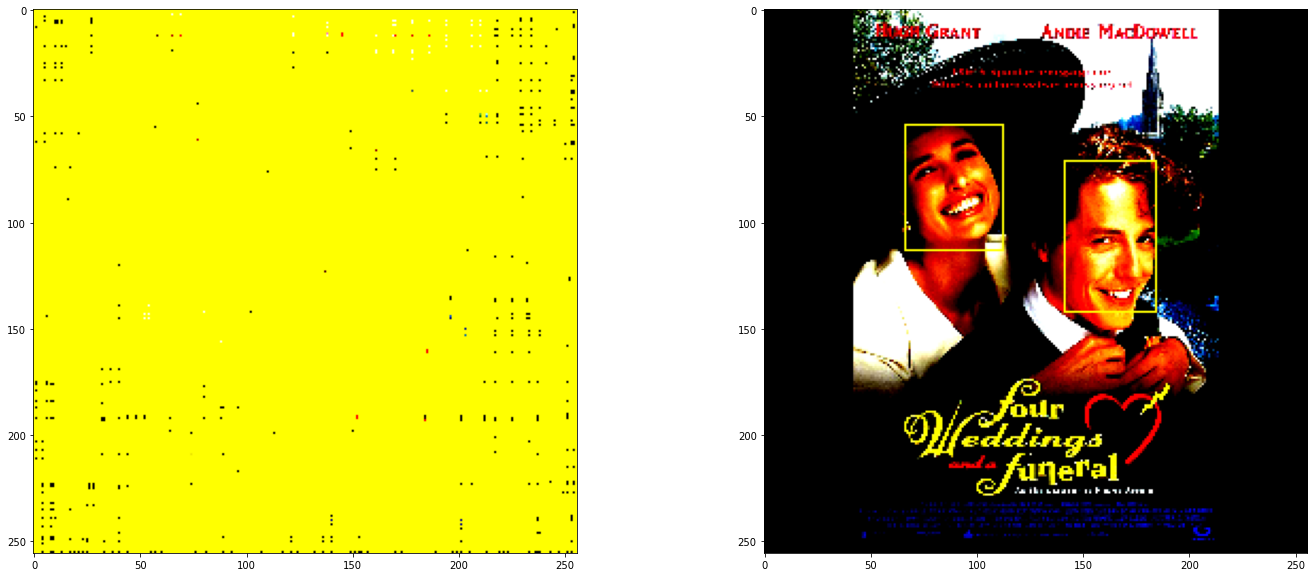

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 10))
index = np.random.randint(0, small.shape[0])
test_image = X_test[index].copy()
test_small = small[index]
test_medium = medium[index]
test_large = large[index]
for size in [test_small, test_medium, test_large]:
  for i in range(size.shape[0]):
    for j in range(size.shape[1]):
      for t in range(size.shape[2]):
        if size[i, j, t, :].any():
          bbx = (size[i, j, t, 1:] * image_size).astype(np.int32)
          test_image = cv.rectangle(test_image, (bbx[0], bbx[1]), (bbx[0] + bbx[2], bbx[1] + bbx[3]), (255, 255, 0), 1)
ax[0].imshow(test_image)

test_image_supressed = X_test[index].copy()
boxes = list_boxes[index]
if boxes is not None:
  for box_index in range(boxes.shape[0]):
      box = boxes[box_index]
      box = (box * image_size).astype(np.int32)
      test_image_supressed = cv.rectangle(test_image_supressed, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 255, 0), 1)
ax[1].imshow(test_image_supressed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

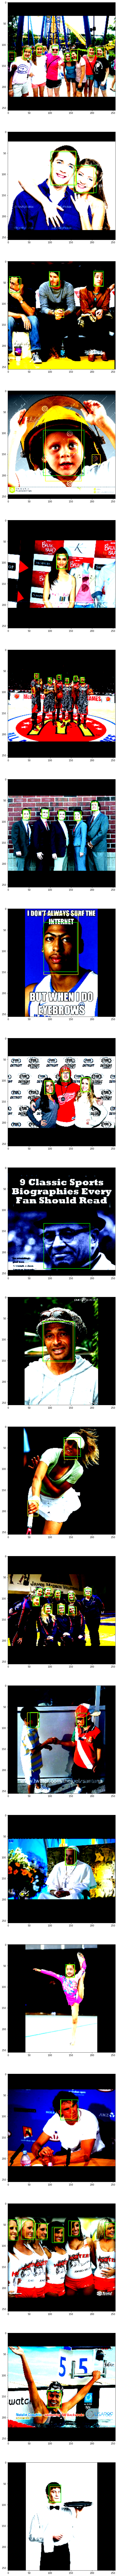

In [ ]:
indices = np.random.randint(0, len(list_boxes), 20)
fig, ax = plt.subplots(20, 1, figsize=(24, 200))
assert(len(Y_test) == len(list_boxes))
for i, image_index in enumerate(indices):
  test_image = X_test[image_index].copy()
  boxes = list_boxes[image_index]
  true_boxes = Y_test[image_index]
  if boxes is not None:
    for box_index in range(boxes.shape[0]):
      box = boxes[box_index]
      box = (box * image_size).astype(np.int32)
      test_image = cv.rectangle(test_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 255, 0), 1)

  for true_box_index in range(true_boxes.shape[0]):
    true_box = true_boxes[true_box_index]
    true_box = (true_box * image_size).astype(np.int32)
    test_image = cv.rectangle(test_image, (true_box[0], true_box[1]), (true_box[0] + true_box[2], true_box[1] + true_box[3]), (0, 255, 0), 1)
  ax[i].imshow(test_image)